## Original code comes from Data-X: https://github.com/ikhlaqsidhu/data-x

## Import packages

In [1]:
# No warnings
import warnings
warnings.filterwarnings('ignore') # Filter out warnings

# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

pd.set_option('display.max_columns', 100) # Print 100 Pandas columns

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.neural_network import MLPClassifier #Neural Net
from sklearn.metrics import accuracy_score #Scoring for the Neural Net

# Plot styling
sns.set(style='white', context='notebook', palette='deep')
plt.rcParams[ 'figure.figsize' ] = 10 , 6

### Define fancy plot to look at distributions

In [2]:
# Special distribution plot (will be used later)
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()
    plt.tight_layout()

## Input Data

In [3]:
train_df = pd.read_csv('train.csv')

# Exploratory Data Anlysis (EDA)
We will analyze the data to see how we can work with it and what makes sense.

In [4]:
print(train_df.columns.values) 

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [5]:
# preview the data
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# General data statistics
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


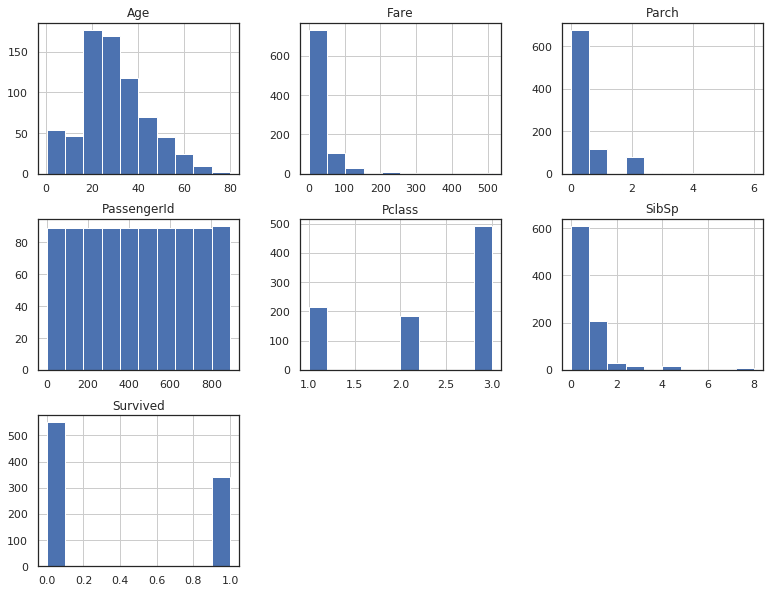

In [7]:
train_df.hist(figsize=(13,10))
plt.show()

In [8]:
# Balanced data set?
train_df['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [9]:
_[0]/(sum(_)) #base line for prediction accuracy

0.6161616161616161

# Preprocessing Data

In [10]:
# check dimensions of the train dataset
print("Shapes Before: (train) = ", \
      train_df.shape)

Shapes Before: (train) =  (891, 12)


In [11]:
# Check if there are null values in the dataset
print(train_df.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


## Hypotheses

## 1: The Title of the person is a feature that can predict survival

In [12]:
# List example titles in Name column
train_df.Name[:5]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [13]:
# from the Name column we will extract title of each passenger
# and save that in a column in the dataset called 'Title'

# Create new column called title
train_df['Title'] = train_df['Name'].str.extract(' ([A-Za-z]+)\.',expand=False)
    
# We see common titles like Miss, Mrs, Mr, Master are dominant, we will
# correct some Titles to standard forms and replace the rarest titles 
# with single name 'Uncommon'

train_df['Title'] = train_df['Title'].\
        replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr',\
        'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Uncommon')

train_df['Title'] = train_df['Title'].replace('Mlle', 'Miss') #Mademoiselle
train_df['Title'] = train_df['Title'].replace('Ms', 'Miss')
train_df['Title'] = train_df['Title'].replace('Mme', 'Mrs') #Madame

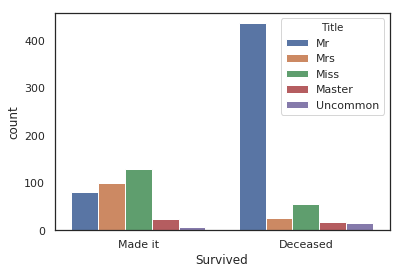

In [14]:
# Plot it
sns.countplot(x='Survived', hue="Title", data=train_df, order=[1,0])
plt.xticks(range(2),['Made it','Deceased']);

In [15]:
# Title dummy mapping
# Map titles to binary dummy columns
binary_encoded = pd.get_dummies(train_df.Title)
newcols = binary_encoded.columns
train_df[newcols] = binary_encoded

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Master,Miss,Mr,Mrs,Uncommon
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0,0,1,0,0


In [16]:
# Remove columns that we won't use
train_df = train_df.drop(['PassengerId','Name', 'Title','Parch', 'SibSp','Embarked','Ticket', 'Cabin'], axis=1)

In [17]:
train_df.head()

,Survived,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Uncommon
0,0,3,male,22.0,7.2500,0,0,1,0,0
1,1,1,female,38.0,71.2833,0,0,0,1,0
2,1,3,female,26.0,7.9250,0,1,0,0,0
3,1,1,female,35.0,53.1000,0,0,0,1,0
4,0,3,male,35.0,8.0500,0,0,1,0,0


### Map Sex column to binary (male = 0, female = 1) categories

In [18]:
train_df['Sex'] = train_df['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Uncommon
0,0,3,0,22.0,7.2500,0,0,1,0,0
1,1,1,1,38.0,71.2833,0,0,0,1,0
2,1,3,1,26.0,7.9250,0,1,0,0,0
3,1,1,1,35.0,53.1000,0,0,0,1,0
4,0,3,0,35.0,8.0500,0,0,1,0,0


### Fill in missing ages with mean

In [19]:
print("Median Age: ",train_df.Age.median())

print("Mean Age: ",train_df.Age.mean())
            
# We'll use the mean
train_df['Age'] = train_df['Age'].fillna(train_df.Age.mean())

Median Age:  28.0
Mean Age:  29.69911764705882


## Finished

In [20]:
train_df.head(7)
# All features are approximately on the same scale
# no need for feature engineering / normalization

,Survived,Pclass,Sex,Age,Fare,Master,Miss,Mr,Mrs,Uncommon
0,0,3,0,22.000000,7.2500,0,0,1,0,0
1,1,1,1,38.000000,71.2833,0,0,0,1,0
2,1,3,1,26.000000,7.9250,0,1,0,0,0
3,1,1,1,35.000000,53.1000,0,0,0,1,0
4,0,3,0,35.000000,8.0500,0,0,1,0,0
5,0,3,0,29.699118,8.4583,0,0,1,0,0
6,0,1,0,54.000000,51.8625,0,0,1,0,0


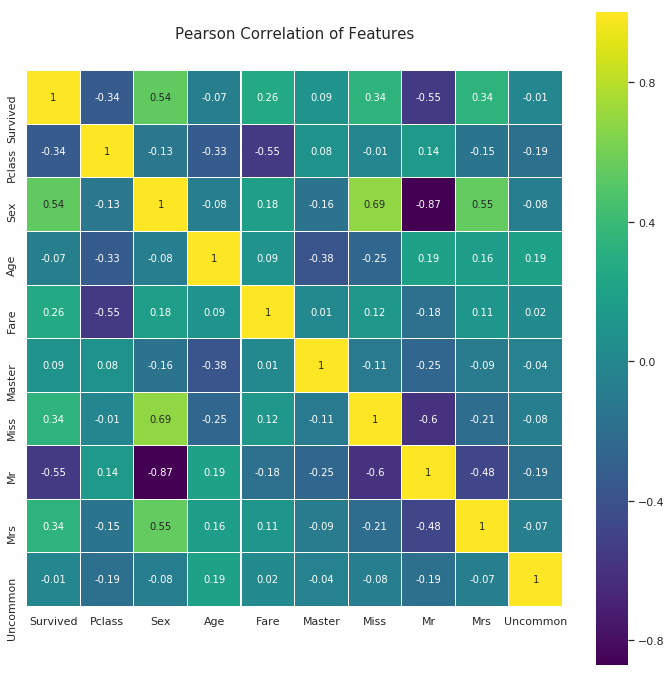

In [21]:
# Check correlation between features 
# (uncorrelated features are generally more powerful predictors)
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_df.corr().round(2)\
            ,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, \
            linecolor='white', annot=True);

# Next Up: Machine Learning!
Now we will Model, Predict, and Choose algorithm for conducting the classification
Try using different classifiers to model and predict. Choose the best model from:
* Logistic Regression
* KNN 
* Random Forest
* Neural Net

## Setup Train and Validation Set

In [22]:
X = train_df.drop("Survived", axis=1) # Training & Validation data
Y = train_df["Survived"] # Response / Target Variable

print(X.shape, Y.shape)

(891, 9) (891,)


In [23]:
# Split training set so that we test on 20% of the data
# Note that our algorithms will never have seen the validation 
# data during training. This is to evaluate how good our estimators are.

np.random.seed(1337) # set random seed for reproducibility

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(712, 9) (712,)
(179, 9) (179,)


## Scikit-Learn general ML workflow
1. Instantiate model object
2. Fit model to training data
3. Let the model predict output for unseen data
4. Compare predicitons with actual output to form accuracy measure

# Models

In [24]:
logreg = LogisticRegression() # instantiate
logreg.fit(X_train, Y_train) # fit
Y_pred_train = logreg.predict(X_train) # predict
acc_log_train = sum(Y_pred_train == Y_train)/len(Y_train)*100
print('Logistic Regression Training Accuracy:', str(round(acc_log_train,2)),'%')

Y_pred = logreg.predict(X_val) # predict
acc_log = sum(Y_pred == Y_val)/len(Y_val)*100
print('Logistic Regression Validation Accuracy:', str(round(acc_log,2)),'%')

Logistic Regression Training Accuracy: 80.2 %
Logistic Regression Validation Accuracy: 80.45 %


In [25]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
print('K-nearest Neighbors Training Accuracy:', str(round(knn.score(X_train, Y_train)*100,2)),'%')

acc_knn = knn.score(X_val, Y_val)
print('K-nearest Neighbors Validation Accuracy:', str(round(acc_knn*100,2)),'%')

K-nearest Neighbors Training Accuracy: 84.69 %
K-nearest Neighbors Validation Accuracy: 71.51 %


In [26]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=10)
random_forest.fit(X_train, Y_train)
print('Random Forest Training Accuracy:', str(round(random_forest.score(X_train, Y_train)*100,2)),'%')

acc_random_forest = random_forest.score(X_val, Y_val)
acc_random_forest
print('Random Forest Validation Accuracy:', str(round(acc_random_forest*100,2)),'%')

Random Forest Training Accuracy: 97.19 %
Random Forest Validation Accuracy: 84.36 %


In [27]:
# Neural Net
hidden_lay = 10
hidden_node = 10

NN_model = MLPClassifier(hidden_layer_sizes=(hidden_lay, hidden_node), activation='relu',solver='lbfgs').fit(X_train,Y_train)

print('Neural Net Training Accuracy:', str(round(accuracy_score(Y_train,NN_model.predict(X_train))*100,2)),'%')

print('Neural Net Validation Accuracy:', str(round(accuracy_score(Y_val,NN_model.predict(X_val))*100,2)),'%')

Neural Net Training Accuracy: 79.35 %
Neural Net Validation Accuracy: 79.33 %


In [28]:
# Neural Net with more layers
hidden_lay = 30
hidden_node = 10

NN_model = MLPClassifier(hidden_layer_sizes=(hidden_lay, hidden_node), activation='relu',solver='lbfgs').fit(X_train,Y_train)

print('Neural Net Training Accuracy:', str(round(accuracy_score(Y_train,NN_model.predict(X_train))*100,2)),'%')

print('Neural Net Validation Accuracy:', str(round(accuracy_score(Y_val,NN_model.predict(X_val))*100,2)),'%')

Neural Net Training Accuracy: 81.04 %
Neural Net Validation Accuracy: 78.21 %


# Importance scores in the random forest model

Training accuracy Random Forest: 0.9719101123595506


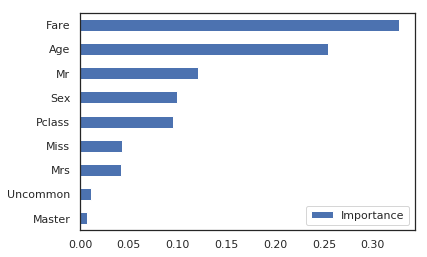

In [29]:
# Look at importnace of features for random forest

def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print ('Training accuracy Random Forest:',model.score( X , y ))

plot_model_var_imp(random_forest, X_train, Y_train)